In [71]:
import glob
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.feature import hog

### Step 1 - Read Images

In [5]:

vehicle_image_arr=[]
vehicle_images_GTI_Far = glob.glob('./vehicles/vehicles/GTI_Far/*.png')
vehicle_images_GTI_Left = glob.glob('./vehicles/vehicles/GTI_Left/*.png')
vehicle_images_GTI_MiddleClose = glob.glob('./vehicles/vehicles/MiddleClose/*.png')
vehicle_images_GTI_Right = glob.glob('./vehicles/vehicles/GTI_Right/*.png')
vehicle_images_KITTI_extracted = glob.glob('./vehicles/vehicles/KITTI_extracted/*.png')
vehicle_image_arr = np.concatenate([vehicle_images_GTI_Far, vehicle_images_GTI_Left, vehicle_images_GTI_MiddleClose, vehicle_images_GTI_Right, vehicle_images_KITTI_extracted])

vehicle_images_original=[]
for imagePath in vehicle_image_arr:
    readImage=cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    vehicle_images_original.append(rgbImage)

print('Reading of Vehicle Images Done')

non_vehicle_image_arr=[]
non_vehicle_images_Extras = glob.glob('./non-vehicles/non-vehicles/Extras//*.png')
non_vehicle_images_GTI = glob.glob('./non-vehicles/non-vehicles/GTI/*.png')
non_vehicle_image_arr= np.concatenate([non_vehicle_images_Extras,non_vehicle_images_GTI])


non_vehicle_images_original=[]
for imagePath in non_vehicle_image_arr:
    readImage=cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    non_vehicle_images_original.append(rgbImage)

print("Reading of Non Vehicle Images Done")

print("No of Vehicle Images Loaded -"+ str(len(vehicle_image_arr)))
print("No of Non-Vehicle Images Loaded -"+ str(len(non_vehicle_images_original)))

Reading of Vehicle Images Done
Reading of Non Vehicle Images Done
No of Vehicle Images Loaded 8373
No of Non-Vehicle Images Loaded 8968


Shape of Vehicle Image(64, 64, 3)
Shape of Non Vehicle Image(64, 64, 3)


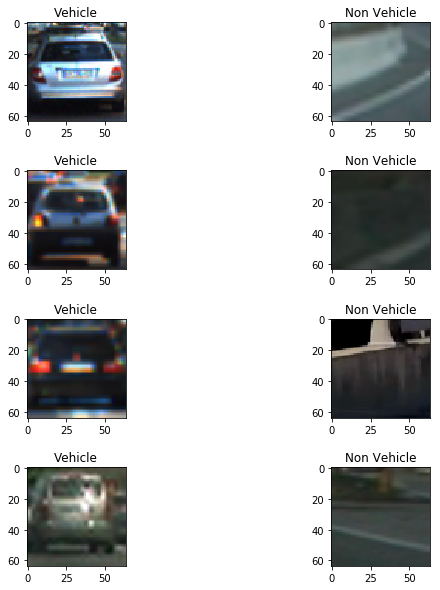

In [14]:
# Visualizing the Vehicle and Non Vehicle Images


f, axes = plt.subplots(4,2, figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

for index in range(4):
    vehicle=random.randint(0, len(vehicle_images_original)-1)
    non_vehicle=random.randint(0, len(non_vehicle_images_original)-1)
    axes[index,0].imshow(vehicle_images_original[vehicle])
    axes[index,0].set_title("Vehicle")
    axes[index,1].imshow(non_vehicle_images_original[non_vehicle])
    axes[index,1].set_title("Non Vehicle")
print("Shape of Vehicle Image" +  str(vehicle_images_original[vehicle].shape))
print("Shape of Non Vehicle Image" +  str(non_vehicle_images_original[non_vehicle].shape))

### Step 2- Extract Features

In [57]:
### 2.1 Experimenting with Color Spaces
### Extract Color Space

def ExtractColorHistogram(image, nbins=32, bins_range=(0,255), resize=None):
    if(resize !=None):
        image= cv2.resize(image, resize)
    zero_channel= np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    first_channel= np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    second_channel= np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    return zero_channel,first_channel, second_channel

def FindBinCenter(histogram_channel):
    bin_edges = histogram_channel[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    return bin_centers

def ExtractColorFeatures(zero_channel, first_channel, second_channel):
    return np.concatenate((zero_channel[0], first_channel[0], second_channel[0]))


No of features are 384


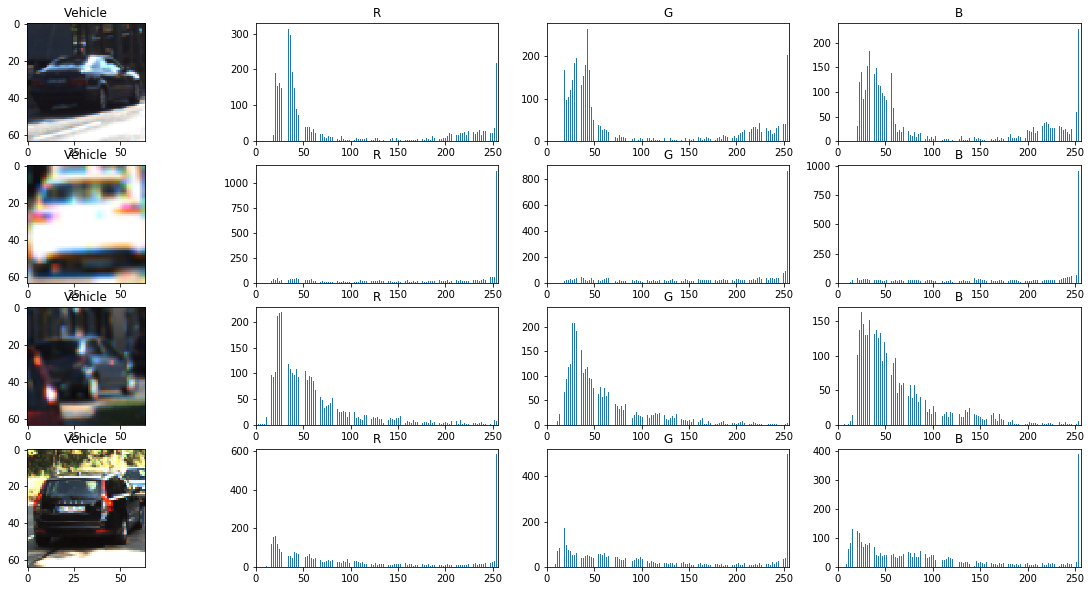

In [61]:
# Checking Color Features for Vehicles

f, axes= plt.subplots(4,4, figsize=(20,10))


for index in range(4):
    
    vehicle=random.randint(0, len(vehicle_images_original)-1)
    non_vehicle=random.randint(0, len(non_vehicle_images_original)-1)
    
    r,g,b = ExtractColorHistogram(vehicle_images_original[vehicle],128)
   
    center= FindBinCenter(r)
    axes[index,0].imshow(vehicle_images_original[vehicle])
    axes[index,0].set_title("Vehicle")
    axes[index,1].set_xlim(0,256)
    axes[index,1].bar(center,r[0])
    axes[index,1].set_title("R")
    axes[index,2].set_xlim(0,256)
    axes[index,2].bar(center,g[0])
    axes[index,2].set_title("G")
    axes[index,3].set_xlim(0,256)
    axes[index,3].bar(center,b[0])
    axes[index,3].set_title("B")
    
features = ExtractColorFeatures(r,g,b)
print("No of features are "+ str(len(features)))
    


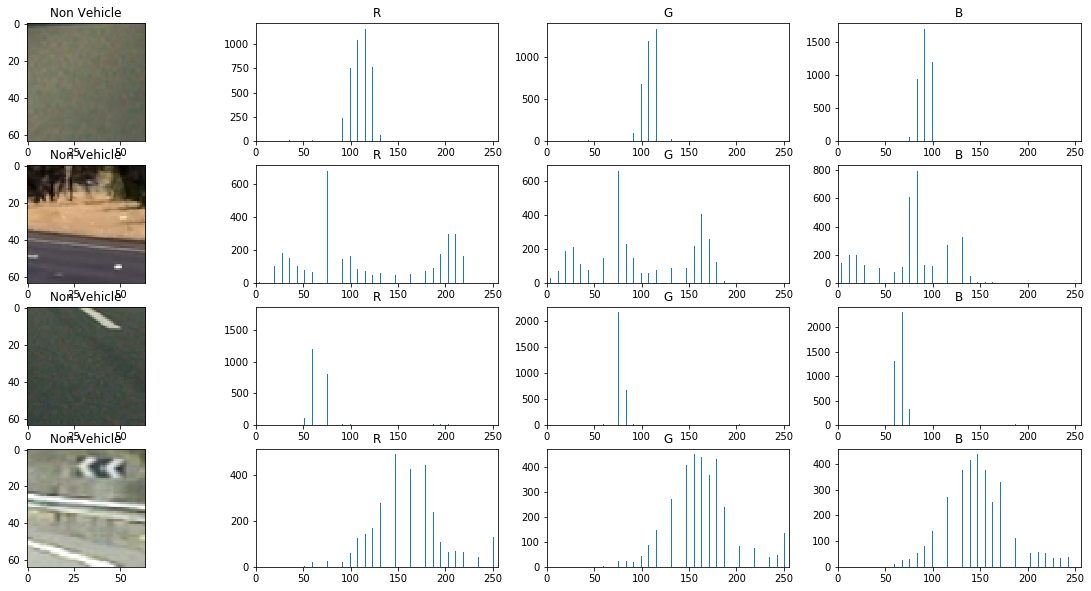

In [63]:
# Checking Color Features for Non Vehicles


f, axes= plt.subplots(4,4, figsize=(20,10))


for index in range(4):
    non_vehicle=random.randint(0, len(non_vehicle_images_original)-1)
    
    r,g,b = ExtractColorHistogram(non_vehicle_images_original[non_vehicle])
    center= FindBinCenter(r)
    axes[index,0].imshow(non_vehicle_images_original[non_vehicle])
    axes[index,0].set_title("Non Vehicle")
    axes[index,1].set_xlim(0,256)
    axes[index,1].bar(center,r[0])
    axes[index,1].set_title("R")
    axes[index,2].set_xlim(0,256)
    axes[index,2].bar(center,g[0])
    axes[index,2].set_title("G")
    axes[index,3].set_xlim(0,256)
    axes[index,3].bar(center,b[0])
    axes[index,3].set_title("B")


### Step 3- Spatial Binning (optional)

In [64]:
def SpatialBinningFeatures(image,size):
    image= cv2.resize(image,size)
    return image.ravel()

In [66]:
featureList=SpatialBinningFeatures(vehicle_images_original[1],(16,16))
print(featureList.shape)

(768,)


### Step 4- HOG

In [99]:
def GetFeaturesFromHog(image,orient,cellsPerBlock,pixelsPerCell):
    hog_features, hog_image = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=True, feature_vector=True,
                          block_norm="L2-Hys")
    return hog_features, hog_image

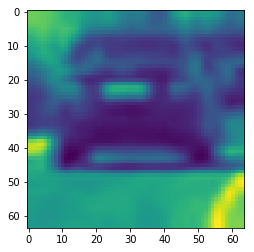

1764


In [103]:
image=vehicle_images_original[1]
image=image[:,:,0]
plt.imshow(image)
plt.show()
featureList,image=GetFeaturesFromHog(image,9,2,8)
print(len(featureList))